# Long Short Term Memory (LSTM) Model

LSTMs are variations of recurrent neural networks.

*Acknowledgments:* Presented with [help](https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning) and [more help](https://github.com/kshitij-raj/Stock-Price-Prediction-LSTM).

In [6]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import  EarlyStopping
from keras import optimizers
from tensorflow import keras

In [2]:
## Load, preprocess data
df = pd.read_csv('./TSLA.csv')

# We will train on closing prices
df = df.reset_index()['Close']
sc = MinMaxScaler()
df = sc.fit_transform(np.array(df).reshape(-1,1))
train, test = train_test_split(df, test_size = 0.2, shuffle = False)

# Modify training, testing data with timesteps
def create_timeseries(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[(i + time_step), 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_timeseries(train, time_step)
X_test, y_test = create_timeseries(test, time_step)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [3]:
## Build and fit LSTM

model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (time_step, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [7]:
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

model.compile(loss = 'mean_squared_error', optimizer = optimizer)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', verbose = 1)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100,
                    batch_size = 64, verbose = 1, callbacks = [early_stop])

Epoch 1/100
35/35 [==============================] - 11s 162ms/step - loss: 0.0017 - val_loss: 0.2071
Epoch 2/100
35/35 [==============================] - 4s 116ms/step - loss: 1.6153e-04 - val_loss: 0.0325
Epoch 3/100
35/35 [==============================] - 4s 119ms/step - loss: 1.6314e-05 - val_loss: 0.0351
Epoch 4/100
35/35 [==============================] - 4s 123ms/step - loss: 1.6052e-05 - val_loss: 0.0404
Epoch 5/100
35/35 [==============================] - 4s 119ms/step - loss: 1.7678e-05 - val_loss: 0.0419
Epoch 6/100
35/35 [==============================] - 4s 126ms/step - loss: 1.3657e-05 - val_loss: 0.0427
Epoch 7/100
35/35 [==============================] - 5s 128ms/step - loss: 1.2703e-05 - val_loss: 0.0436
Epoch 8/100
35/35 [==============================] - 4s 111ms/step - loss: 1.4682e-05 - val_loss: 0.0381
Epoch 9/100
35/35 [==============================] - 4s 116ms/step - loss: 1.5919e-05 - val_loss: 0.0408
Epoch 10/100
35/35 [==============================] - 4s 1

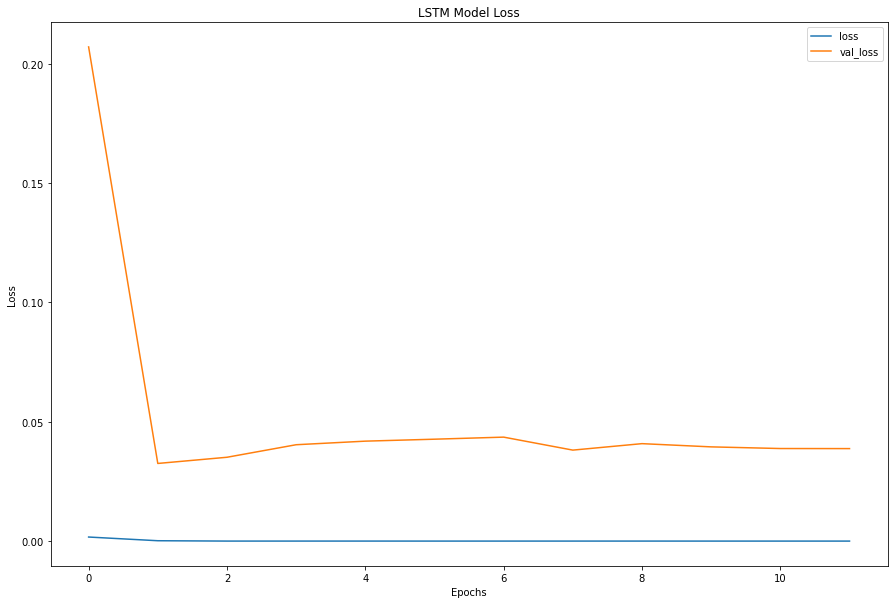

In [8]:
## Analyze Model Loss
plt.figure(figsize = (15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel("Epochs")
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

Here, ``loss`` is the MSE for our training data, and ``val_loss`` is the MSE for our cross-validation data.

In [76]:
##Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Invert transformation to get stock prices
train_pred = sc.inverse_transform(train_pred)
test_pred = sc.inverse_transform(test_pred)

[[-0.00099405]
 [-0.00100677]
 [-0.00103092]
 ...
 [ 0.04491652]
 [ 0.04509752]
 [ 0.0453662 ]]


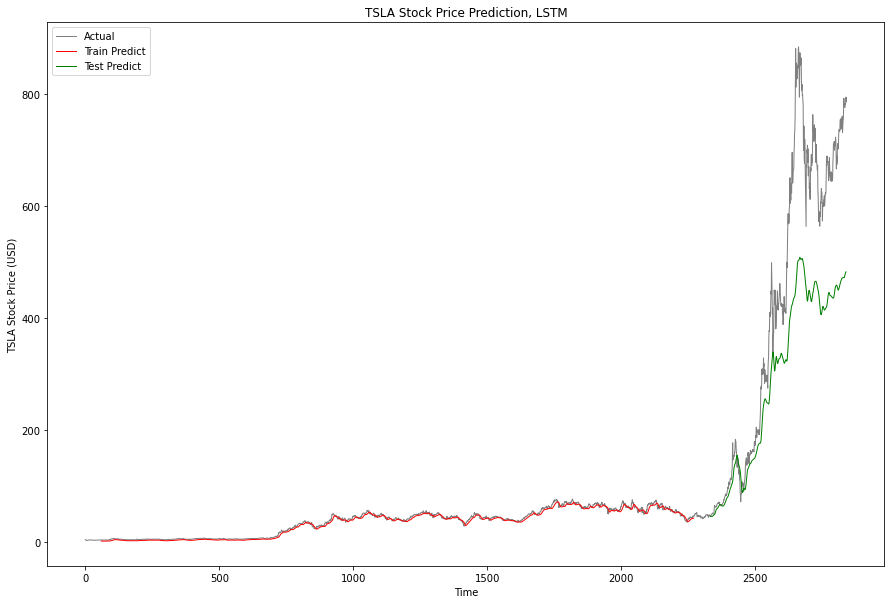

In [10]:
## Observed v. Predicted Results
# Shift train prediction for plotting
train_pred_plot = np.empty_like(df)
train_pred_plot[:, :] = np.nan
train_pred_plot[time_step: len(train_pred) + time_step, :] = train_pred

# Shift test prediction for plotting
test_pred_plot = np.empty_like(df)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + (time_step * 2) + 1: len(df) -1, :] = test_pred

plt.figure(figsize = (15, 10))
plt.plot(sc.inverse_transform(df), color = 'gray', linewidth = 1, label = 'Actual')
plt.plot(train_pred_plot, linewidth = 1, color = 'red', label = 'Train Predict')
plt.plot(test_pred_plot, linewidth = 1, color = 'green', label = 'Test Predict')
plt.legend()
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price (USD)')
plt.title('TSLA Stock Price Prediction, LSTM')
plt.show()

Hyperparameter Turning using Bayesian Optimization

In [51]:
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=8,
                               max_value=64, step=8),
                   return_sequences=True, input_shape = (time_step,1)))
    
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', metrics = ['mse'], 
                  optimizer = keras.optimizers.Adam(
                      hp.Choice('learning_rate', values = [0.01,0.001,0.0001])))
    return model

bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=20,
    executions_per_trial=1, overwrite=True,
    project_name='LSTM_Tesla_stock_price'
)

bayesian_opt_tuner.search(X_train, y_train, epochs = 100,
                         validation_data=(X_test, y_test),
                         verbose = 1, batch_size = 64, 
                         callbacks = [early_stop]
                         )

Trial 20 Complete [00h 00m 36s]
mse: 0.0006592595018446445

Best mse So Far: 0.0006584640359506011
Total elapsed time: 00h 15m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [78]:
best_hp = bayesian_opt_tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'units': 64, 'learning_rate': 0.01}


In [79]:
bayesian_opt_tuner.results_summary()

Results summary
Results in ./LSTM_Tesla_stock_price
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.0006584640359506011
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.0006590652046725154
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.01
Score: 0.0006592018762603402
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.01
Score: 0.0006592595018446445
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.01
Score: 0.0006598926847800612
Trial summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 0.0006601425120607018
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.0006602310459129512
Trial summary
Hyperparameters:
units: 56
learning_rate: 0.01
Score: 0.0006603226065635681
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.0006604972877539694
Trial summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 0.000660